In [134]:
# Initialize Otter
import otter
grader = otter.Notebook("project3.ipynb")

<img style="display: block; margin-left: auto; margin-right: auto" src="./ccsf-logo.png" width="250rem;" alt="The CCSF black and white logo">

<div style="text-align: center;">
    <h1>Project 3: Movie Classification</h1>
    <em>View the related <a href="https://ccsf.instructure.com" target="_blank">Canvas</a> Assignment page for additional details.</em>
</div>

In this project, you will build a classification model that guesses whether a movie is a comedy or a thriller by using only the number of times chosen words appear in the movie's screenplay. By the end of the project, you should know how to:

1. Build a k-nearest-neighbors classifier.
2. Test a classifier on data.

In [135]:
import datascience
import statsmodels
import math
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter("ignore")

## 💾 Part 1: The Dataset

In this project, we are exploring movie screenplays. We'll be trying to predict each movie's genre from the text of its screenplay. In particular, we have compiled a list of 5,000 words that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

Run the cell below to read the `movies` table. **It may take up to a minute to load.**

In [136]:
movies = Table.read_table('movies.csv')
movies.show(3)

Here is one row of the table and some of the frequencies of words that were said in the movie.

In [137]:
movies.where("Title", "runaway bride").select(0, 1, 2, 3, 4, 14, 49, 1042, 4004)

Title,Year,Rating,Genre,# Words,breez,england,it,bravo
runaway bride,1999,5.2,comedy,4895,0,0,0.0234092,0


The above cell prints a few columns of the row for the comedy movie *Runaway Bride*.  The movie contains 4895 words. The word "it" appears 115 times, as it makes up  $\frac{115}{4895} \approx 0.0234092$ of the words in the movie. The word "england" doesn't appear at all.

Additional context: This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. This is a model that is often used in [NLP](https://en.wikipedia.org/wiki/Natural_language_processing). A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format. 

In this project, we will investigate whether this representation is sufficient to build an accurate genre classifier.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

*Note: All movies in our dataset have their titles lower-cased.* 

In [138]:
title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

row_for_title('toy story');

For example, the fastest way to find the frequency of "fun" in the movie *Toy Story* is to access the `'fun'` item from its row. Check the original table to see if this worked for you!

In [139]:
row_for_title('toy story').item('fun') 

0.00034855350296270001

#### Task 1.1 📍

Set `expected_row_sum` to the number that you __expect__ will result from summing all proportions in each row, excluding the first five columns. Think about what any one row adds up to.

_Points:_ 2

In [140]:
# Set row_sum to a number that's the (approximate) sum of each row of word proportions.
expected_row_sum = 1

In [141]:
grader.check("task_1_1")

task_1_1 results: All test cases passed!
task_1_1 - 1 message: ✅ expected_row_sum is greater than 0.

This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing the naughty words, and converting the counts to frequencies), we created this new dataset containing the frequency of 5000 common words in each movie.

In [142]:
print('Words with frequencies:', movies.drop(np.arange(5)).num_columns) 
print('Movies with genres:', movies.num_rows)

Words with frequencies: 5000
Movies with genres: 333


### Section 1.1: Word Stemming

The columns other than "Title", "Year", "Rating", "Genre", and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset.  These words have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie. This is a common technique used in machine learning and natural language processing.

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table called `vocab_table` that will let you see examples of unstemmed versions of each stemmed word. Run the code below to load it.

**Note:** You should use `vocab_table` for the rest of Section 1.1, not `vocab_mapping`. 

In [143]:
# Just run this cell.
vocab_mapping = Table.read_table('stem.csv')
stemmed = np.take(movies.labels, np.arange(3, len(movies.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1110))

Stem,Word
bond,bonding
bone,bone
bone,boning
bone,bones
bonu,bonus
book,bookings
book,books
book,booking
book,booked
book,book


#### Task 1.1.1 📍

Using `vocab_table`, find the stemmed version of the word "elements" and assign the value to `stemmed_message`.


_Points:_ 3

In [144]:
vocab_table.where(1,'elements').column(0).item(0)

'element'

In [145]:
stemmed_message = vocab_table.where(1,'elements').column(0).item(0)
stemmed_message

'element'

In [146]:
grader.check("task_1_1_1")

task_1_1_1 results: All test cases passed!
task_1_1_1 - 1 message: ✅ stemmed_message is a string.
task_1_1_1 - 2 message: ✅ The length of stemmed_message is less than the lenght of 'elements'.

#### Task 1.1.2 📍

What stem in the dataset has the most words that are shortened to it? Assign `most_stem` to that stem. 

_Points:_ 2

In [147]:
most_stem = vocab_table.group(0).sort(1,True).column(0).item(0)
most_stem

'gener'

In [148]:
grader.check("task_1_1_2")

task_1_1_2 results: All test cases passed!
task_1_1_2 - 1 message: ✅ most_stem is a string.

#### Task 1.1.3 📍

What is the longest word in the dataset whose stem wasn't shortened? Assign that to `longest_uncut`. Break ties alphabetically from Z to A (so if your options are "cat" or "bat", you should pick "cat"). Note that when sorting letters, the letter `a` is smaller than the letter `z`.

*Hint 1:* `vocab_table` has 2 columns: one for stems and one for the unstemmed (normal) word. Find the longest word that wasn't cut at all (same length as stem).

*Hint 2:* There is a table function that allows you to compute a function on every element in a column. Check [Python Reference](http://data8.org/sp22/python-reference.html) if you aren't sure which one.

*Hint 3:* Check the comments in the cell below if you are stuck.

_Points:_ 2

In [149]:
# In our solution, we found it useful to first add columns with
# the length of the word and the length of the stem,
# and then to add a column with the difference between those lengths.
# What will the difference be if the word is not shortened?
lens1=vocab_table.apply(len,0)
lens2=vocab_table.apply(len,1)

stem_diff=lens2-lens1
tbl_with_lens = vocab_table.with_columns('Stem len',lens1,'Word len',lens2)
tbl_with_diff = tbl_with_lens.with_column('stem_diff',stem_diff)
no_diff=tbl_with_diff.where(4,0).sort(2,True)
longest_uncut=no_diff.where(2,13).sort('Word',True).column(1).item(0)

In [150]:
grader.check("task_1_1_3")

task_1_1_3 results: All test cases passed!
task_1_1_3 - 1 message: ✅ longest_uncut is a string.

#### Task 1.1.4 📍

How many stems have only one word that is shortened to them? For example, if the stem "book" only maps to the word "books" and if the stem "a" only maps to the word "a," both should be counted as stems that map only to a single word.

Assign `count_single_stems` to the count of stems that map to one word only. 

_Points:_ 2

In [151]:
count_single_stems = vocab_table.group(0).where(1,1).num_rows
count_single_stems

1408

In [152]:
grader.check("task_1_1_4")

task_1_1_4 results: All test cases passed!
task_1_1_4 - 1 message: ✅ count_single_stems is an integer.

### Section 1.2: Exploratory Data Analysis: Linear Regression

Let's explore our dataset before trying to build a classifier. To start, we’ll use the associated proportions to investigate the relationship between different words.

The first association we'll investigate is the association between the proportion of words that are "outer" and the proportion of words that are "space". 

As usual, we'll investigate our data visually before performing any numerical analysis.

Run the cell below to plot a scatter diagram of "space" proportions vs "outer" proportions and to create the `outer_space` table. Each point on the scatter plot represents one movie.

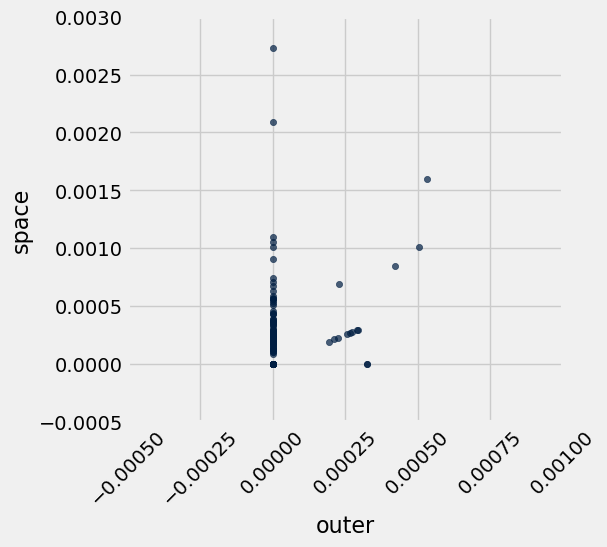

In [153]:
# Just run this cell!
outer_space = movies.select("outer", "space")
outer_space.scatter("outer", "space")
plots.axis([-0.0005, 0.001, -0.0005, 0.003]);
plots.xticks(rotation=45);

#### Task 1.2.1 📍

Looking at that chart it is difficult to see if there is an association. Calculate the correlation coefficient for the potential linear association between proportion of words that are "outer" and the proportion of words that are "space" for every movie in the dataset, and assign it to `outer_space_r`. 

*Hint:* If you need a refresher on how to calculate the correlation coefficient check out [Ch 15.1](https://inferentialthinking.com/chapters/15/1/Correlation.html#calculating-r).

_Points:_ 2

In [154]:
# These two arrays should make your code cleaner!
outer = movies.column("outer")
space = movies.column("space")

outer_su = (outer - np.mean(outer))/np.std(outer)  
space_su = (space - np.mean(space))/np.std(space)  

outer_space_r = np.mean(outer_su*space_su)
outer_space_r

0.31942607876895912

In [155]:
grader.check("task_1_2_1")

task_1_2_1 results: All test cases passed!
task_1_2_1 - 1 message: ✅ outer_space_r is between 0.2 and 0.4.

#### Task 1.2.2 📍🔎

<!-- BEGIN QUESTION -->

Choose two *different* words in the dataset with a magnitude (absolute value) of correlation higher than 0.2 and plot a scatter plot with a line of best fit for them. Please do not pick "outer" and "space" or "san" and "francisco". The code to plot the scatter plot and line of best fit is given for you, you just need to calculate the correct values to `r`, `slope` and `intercept`. 

*Hint 1:* It's easier to think of words with a positive correlation, i.e. words that are often mentioned together*. Try to think of common phrases or idioms.

*Hint 2:* Refer to [Section 15.2](https://inferentialthinking.com/chapters/15/2/Regression_Line.html#units-of-measurement-of-the-slope) of the textbook for the formulas. 

_Points:_ 2

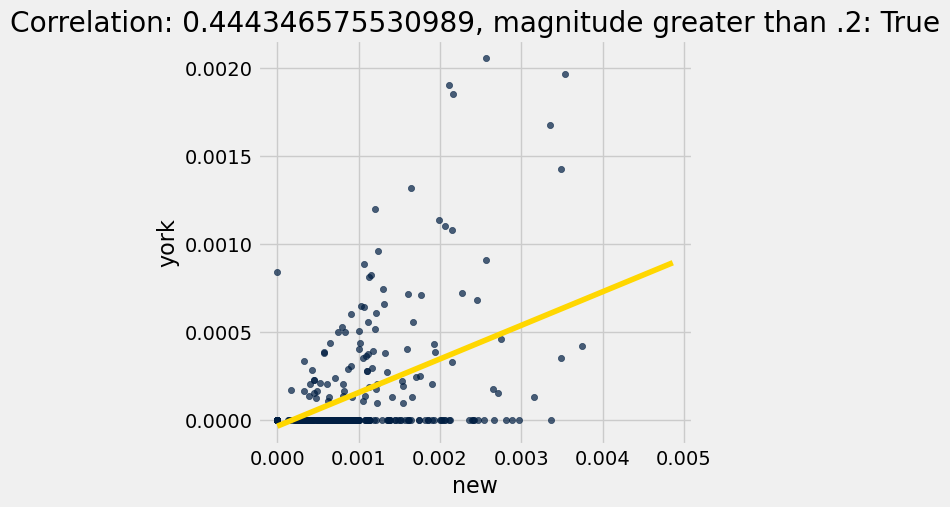

In [156]:
word_x = 'new'
word_y = 'york'

# These arrays should make your code cleaner!
arr_x = movies.column(word_x)
arr_y = movies.column(word_y)

x_su = (arr_x - np.mean(arr_x))/np.std(arr_x)  
y_su = (arr_y - np.mean(arr_y))/np.std(arr_y)  

r = np.mean(x_su*y_su)

slope = r*np.std(arr_y)/np.std(arr_x)
intercept = np.mean(arr_y) - slope *np.mean(arr_x)

# DON'T CHANGE THESE LINES OF CODE
movies.scatter(word_x, word_y)
max_x = max(movies.column(word_x))
plots.title(f"Correlation: {r}, magnitude greater than .2: {abs(r) >= 0.2}")
plots.plot([0, max_x * 1.3], [intercept, intercept + slope * (max_x*1.3)], color='gold');

<!-- END QUESTION -->

#### Task 1.2.3 📍

Imagine that you picked the words "san" and "francisco" as the two words that you would expect to be correlated because they compose the city name San Francisco. Assign `san_francisco` to either the number 1 or the number 2 according to which statement is true regarding the correlation between "san" and "francisco." 

1. "san" can also preceed other city names like San Diego and San Jose. This might lead to "san" appearing in movies without "francisco," and would reduce the correlation between "san" and "francisco."
2. "san" can also preceed other city names like San Diego and San Jose. The fact that "san" could appear more often in front of different cities and without "francisco" would increase the correlation between "san" and "francisco." 

_Points:_ 2

In [157]:
san_francisco = 1

In [158]:
grader.check("task_1_2_3")

task_1_2_3 results: All test cases passed!
task_1_2_3 - 1 message: ✅ san_francisco is an integer.

### Section 1.3: Splitting the dataset

Now, we're going to use our `movies` dataset for two purposes.

1. First, we want to *train* movie genre classifiers.
2. Second, we want to *test* the performance of our classifiers. 

Hence, we need two different datasets: *training* and *test*. 

The purpose of a classifier is to classify unseen data that is similar to the training data. The test dataset will help us determine the accuracy of our predictions by comparing the actual genres of the movies with the genres that our classifier predicts. Therefore, we must ensure that there are no movies that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the first 85% of the dataset for training and the rest for test. 

Run the code below (without changing it) to separate the datasets into two tables.

In [159]:
# Here we have defined the proportion of our data
# that we want to designate for training as 17/20ths
# of our total dataset.  3/20ths of the data is
# reserved for testing.

training_proportion = 17/20

num_movies = movies.num_rows
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.take(np.arange(num_train))
test_movies = movies.take(np.arange(num_train, num_movies))

print("Training: ",   train_movies.num_rows, ";",
      "Test: ",       test_movies.num_rows)

Training:  283 ; Test:  50


In [160]:
movies.show(3)

#### Task 1.3.1 📍🔎

<!-- BEGIN QUESTION -->

Draw a horizontal bar chart with two bars that show the proportion of Comedy movies in each dataset (`train_movies` and `test_movies`). The two bars should be labeled "Training" and "Test". Complete the function `comedy_proportion` first; it should help you create the bar chart. 

*Hint*: Refer to [Section 7.1](https://inferentialthinking.com/chapters/07/1/Visualizing_Categorical_Distributions.html#bar-chart) of the textbook if you need a refresher on bar charts.

_Points:_ 2

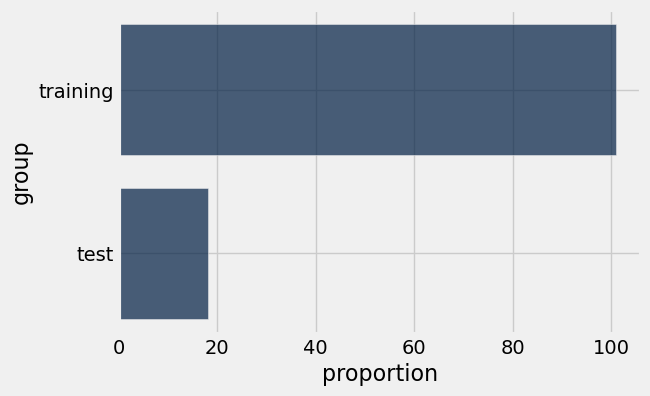

In [161]:
def comedy_proportion(table):
    # Return the proportion of movies in a table that have the comedy genre.
    comedy_propor = table.where('Genre', 'comedy')
    training_proportion = 17/20
    num_mov_comedy = comedy_propor.num_rows #number of movies in 'table' that are comedy genre
    num_train_comedy = int(num_mov_comedy * training_proportion) #number of comedy movies*training proportion= number of training comedy movies in table
    num_test_comedy = num_mov_comedy - num_train_comedy #total num comedy-number of comedy in train
    return num_train_comedy, num_test_comedy

#train_test_comedy= Table().with_columns('
# The staff solution took multiple lines.  Start by creating a table.
# If you get stuck, think about what sort of table you need for barh to work
group=make_array('training','test')
movies_comedy_propor = comedy_proportion(movies)
table_com=Table().with_columns('group',group,'proportion',movies_comedy_propor)
table_com.barh('group')

In [162]:
comedy_proportion(movies)

(101, 18)

In [163]:
comedy_proportion(train_movies)

(86, 16)

In [164]:
comedy_proportion(test_movies)

(14, 3)

<!-- END QUESTION -->

## 🏘️ Part 2: K-Nearest Neighbors - A Guided Example

[K-Nearest Neighbors (k-NN)](https://inferentialthinking.com/chapters/17/1/Nearest_Neighbors.html) is a classification algorithm.  Given some numerical *attributes* (also called *features*) of an unseen example, it decides which category that example belongs to based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) we have about each movie is *the proportion of times a particular word appears in the movie*, and the labels are two movie genres: comedy and thriller.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

To build understanding, we're going to visualize the algorithm instead of just describing it.

### Section 2.1: Classifying a movie

In k-NN, we classify a movie by finding the `k` movies in the *training set* that are most similar according to the features we choose. We call those movies with similar features the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each movie.  The features we will use are the proportions of the words "water" and "feel" in the movie.  Taking the movie *Monty Python and the Holy Grail* (in the test set), 0.000804074 of its words are "water" and 0.0010721 are "feel". This movie appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the *distance* between two movies is the straight-line distance between them when we plot their features on a scatter diagram. 

**This distance is called the Euclidean ("yoo-KLID-ee-un") distance, whose formula is $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$.**

For example, in the movie *Clerks.* (in the training set), 0.00016293 of all the words in the movie are "water" and 0.00154786 are "feel".  Its distance from *Monty Python and the Holy Grail* on this 2-word feature set is $\sqrt{(0.000804074 - 0.000162933)^2 + (0.0010721 - 0.00154786)^2} \approx 0.000798379$.  (If we included more or different features, the distance could be different.)

A third movie, *The Godfather* (in the training set), has 0 "water" and 0.00015122 "feel". 

The function below creates a plot to display the "water" and "feel" features of a test movie and some training movies. As you can see in the result, *Monty Python and the Holy Grail* is more similar to *Clerks.* than to the *The Godfather* based on these features, which makes sense as both movies are comedy movies, while *The Godfather* is a thriller.

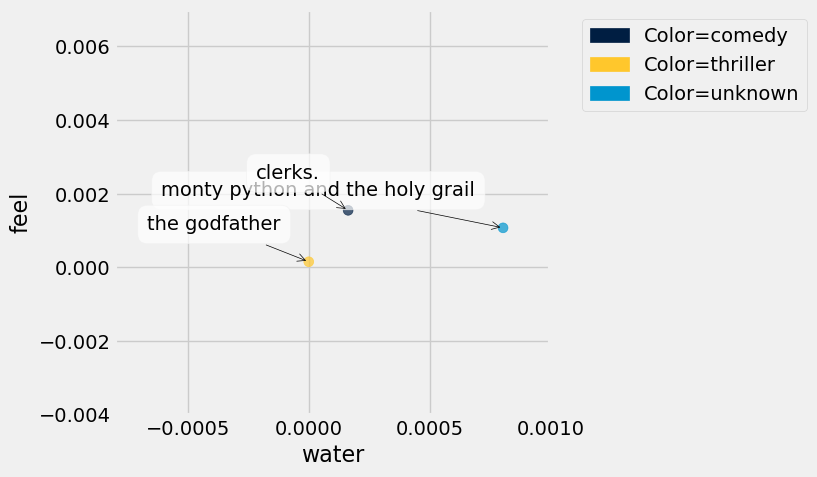

In [165]:
# Just run this cell.
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = row_for_title(test_movie)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['unknown'],
            'Title',   [test_movie]
        )
    for movie in training_movies:
        row = row_for_title(movie)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), movie])
    distances.scatter(x_feature, y_feature, group='Color', labels='Title', s=50)
    
training = ["clerks.", "the godfather"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel")
plots.axis([-0.0008, 0.001, -0.004, 0.007]);

#### Task 2.1.1 📍

Compute the Euclidean distance (defined in the section above) between the two movies, *Monty Python and the Holy Grail* and *The Godfather*, using the `water` and `feel` features only.  Assign it the name `one_distance`. 

*Hint 1:* If you have a row, you can use `item` to get a value from a column by its name.  For example, if `r` is a row, then `r.item("Genre")` is the value in column `"Genre"` in row `r`.

*Hint 2:* Refer to the beginning of Part 1 if you don't remember what `row_for_title` does.

*Hint 3:* In the formula for Euclidean distance, think carefully about what `x` and `y` represent. Refer to the example in the text above if you are unsure.

_Points:_ 2

In [166]:
python = row_for_title("monty python and the holy grail") 
godfather = row_for_title("the godfather") 

x_python = python.item('water')
y_python = python.item('feel')

x_godfather = godfather.item('water')
y_godfather = godfather.item('feel')


one_distance = np.sqrt(((x_python - x_godfather)**2) + ((y_python - y_godfather)**2))
one_distance

0.0012225209151294461

In [167]:
grader.check("task_2_1_1")

task_2_1_1 results: All test cases passed!
task_2_1_1 - 1 message: ✅ one_distance is between 0 and 0.01.

Below, we've added a third training movie, *The Silence of the Lambs*. Before, the point closest to *Monty Python and the Holy Grail* was *Clerks.*, a comedy movie. However, now the closest point is *The Silence of the Lambs*, a thriller movie.

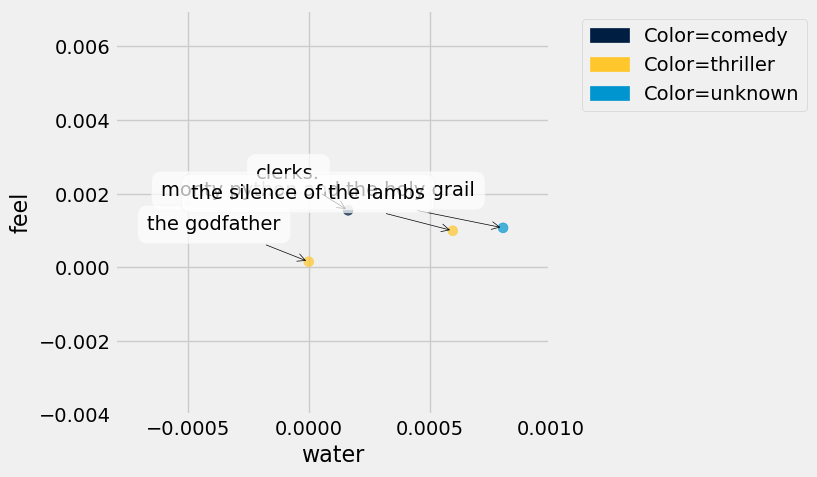

In [168]:
training = ["clerks.", "the godfather", "the silence of the lambs"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel") 
plots.axis([-0.0008, 0.001, -0.004, 0.007]);

#### Task 2.1.2 📍

Complete the function `distance_two_features` that computes the Euclidean distance between any two movies, using two features. The last two lines call your function to show that *Monty Python and the Holy Grail* is closer to *The Silence of the Lambs* than it is to *Clerks*. 

_Points:_ 2

In [169]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two movies with titles title0 and title1.
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = row_for_title(title0) 
    row1 = row_for_title(title1) 
    
    x_row0 = row0.item(x_feature)
    y_row0 = row0.item(y_feature)
    
    x_row1 = row1.item(x_feature)
    y_row1 = row1.item(y_feature)
    distance = np.sqrt(((x_row0 - x_row1)**2) + ((y_row0 - y_row1)**2))
    
    return distance

for movie in make_array("clerks.", "the silence of the lambs"):
    movie_distance = distance_two_features(movie, "monty python and the holy grail", "water", "feel")
    print(movie, 'distance:\t', movie_distance)

clerks. distance:	 0.000798381068723
the silence of the lambs distance:	 0.000222563148556


In [170]:
grader.check("task_2_1_2")

task_2_1_2 results: All test cases passed!
task_2_1_2 - 1 message: ✅ distance_two_features('clerks.', 'the godfather', 'water', 'feel') returned the correct distance.
task_2_1_2 - 2 message: ✅ distance_two_features('clerks.', 'the godfather', 'your', 'that') returned the correct distance.

#### Task 2.1.3 📍

Define the function `distance_from_python` so that it works as described in its documentation. 

**Note:** Your solution should not use arithmetic operations directly. Instead, it should make use of existing functionality above!

_Points:_ 2

In [171]:
def distance_from_python(title):
    """The distance between the given movie and "monty python and the holy grail", 
    based on the features "water" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    distance_from_python_only = distance_two_features(title,"monty python and the holy grail", 'water','feel')
    
    return distance_from_python_only
    
# Calculate the distance between "Clerks." and "Monty Python and the Holy Grail"
distance_from_python('clerks.')

0.00079838106872277164

In [172]:
grader.check("task_2_1_3")

task_2_1_3 results: All test cases passed!
task_2_1_3 - 1 message: ✅ distance_from_python('clerks.') returned a reasonably correct distance.

#### Task 2.1.4 📍

Using the features `"water"` and `"feel"`, what are the names and genres of the 5 movies in the **training set** closest to *Monty Python and the Holy Grail*?  To address this task, make a **table** named `close_movies` containing those 5 movies with columns `"Title"`, `"Genre"`, `"water"`, and `"feel"`, as well as a column called `"distance from python"` that contains the distance from *Monty Python and the Holy Grail*.  The table should be **sorted in ascending order by `"distance from python"`**.

*Note:* Why are smaller distances from *Monty Python and the Holy Grail* more helpful in helping us classify the movie?

*Hint:* Your final table should only have 5 rows. How can you get the first five rows of a table?

_Points:_ 4

In [173]:
distances = train_movies.apply(distance_from_python,'Title')
movies_with_distance = train_movies.with_column('distance from python', distances).sort('distance from python')
close_movies = movies_with_distance.select('Title', 'Genre', 'water', 'feel', 'distance from python').take(np.arange(5))
close_movies

Title,Genre,water,feel,distance from python
alien,thriller,0.00070922,0.00124113,0.000193831
tomorrow never dies,thriller,0.000888889,0.000888889,0.00020189
the silence of the lambs,thriller,0.000595948,0.000993246,0.000222563
innerspace,comedy,0.000522193,0.00104439,0.00028324
some like it hot,comedy,0.000528541,0.000951374,0.00030082


In [174]:
grader.check("task_2_1_4")

task_2_1_4 results: All test cases passed!
task_2_1_4 - 1 message: ✅ close_movies has the correct labels.
task_2_1_4 - 2 message: ✅ close_movies has the correct number of rows.
task_2_1_4 - 3 message: ✅ It seems like you are using the training set.

#### Task 2.1.5 📍

Next, we'll clasify *Monty Python and the Holy Grail* based on the genres of the closest movies. 

To do so, define the function `most_common` so that it works as described in its documentation below. 

_Points:_ 1

In [175]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in the label column of the table.
    In case of a tie, it returns any one of the most common values.    
    """
    genre = table.group(label).sort('count', descending=True).column(0).item(0)
    
    return genre
    

# Calling most_common on your table of 5 nearest neighbors classifies
# "monty python and the holy grail" as a thriller movie, 3 votes to 2. 
most_common('Genre', close_movies)

'thriller'

In [176]:
grader.check("task_2_1_5")

task_2_1_5 results: All test cases passed!
task_2_1_5 - 1 message: ✅ most_common worked correctly for our test case.

Congratulations are in order -- you've classified your first movie! However, we can see that the classifier doesn't work too well since it categorized *Monty Python and the Holy Grail* as a thriller movie (unless you count the thrilling holy hand grenade scene). Let's see if we can do better!

## 👋 Submit your Progress Check to Canvas

Once you have attempted all the tasks in the above, prepare to submit your progress check in Canvas by completing the following steps.

1. Double-check that you have run the code cell near the end of the notebook that contains the command "grader.check_all()". This command will run all of the run tests on all your responses to the code tasks. It is okay if you don't have all the tasks completed in the notebook. We are just checking that you've attempted everything in Part 1 and Part 2.
2. Double-check that you have responded to all the open-response tasks in Part 1 and Part 2.
3. Select the menu items "File", "Save and Export Notebook as ...", and HTML in the notebook's Toolbar to save your work, create a specific checkpoint in the notebook's work history, and download an HTML version of your work.
4. In the related Canvas Assignment, click Start Assignment or New Attempt to upload the downloaded HTML file.

**Keep in mind that the autograder does not always check for correctness. Sometimes it just checks for the format of your answer, so passing the autograder for a task does not mean you got the answer correct for that task.**

## ✨ Part 3: Features

Now, we're going to extend our classifier to consider more than two features at a time.

Euclidean distance still makes sense with more than two features. For `n` different features, we compute the difference between corresponding feature values for two movies, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

### Task 3.1 📍

Write a function called `distance` to compute the Euclidean distance between two **arrays** of **numerical** features (e.g. arrays of the proportions of times that different words appear). The function should be able to calculate the Euclidean distance between two arrays of arbitrary (but equal) length.

Next, use the function you just defined to compute the distance **between the first and second movie** in the **training set** *using all of the features*.  (Remember that the first five columns of your tables are not features.)

*Hint 1:* To convert rows to arrays, use `np.array`. For example, if `t` was a table, `np.array(t.row(0))` converts row 0 of `t` into an array.

*Hint 2:* Make sure to drop the first five columns of the table before you compute `distance_first_to_second`, as these columns do not contain any features (the proportions of words). 

_Points:_ 7

In [177]:
np.array(train_movies.row(0))

array(['10 things i hate about you', '1999', '6.9', ..., '0.0', '0.0',
       '0.0'],
      dtype='<U32')

In [178]:
def distance(features_array1, features_array2):
    """The Euclidean distance between two arrays of feature values."""
    return np.sqrt(np.sum((features_array1 - features_array2)**2))
distance_first_to_second =distance((np.array(train_movies.drop(0,1,2,3,4).row(0))),(np.array(train_movies.drop(0,1,2,3,4).row(1))))
distance_first_to_second

0.033354468908813169

In [179]:
grader.check("task_3_1")

task_3_1 results: All test cases passed!
task_3_1 - 1 message: ✅ distance_first_to_second is betwen 0.0 and 0.1, inclusive.
task_3_1 - 2 message: ✅ distance correctly works when the inputs are the same array.
task_3_1 - 3 message: ✅ distance correctly works for our test input arrays.

### Section 3.1: Creating your own feature set

Unfortunately, using all of the features has some downsides.  One clear downside is the lack of *computational efficiency* -- computing Euclidean distances just takes a long time when we have lots of features.  You might have noticed that in the last task!

So we're going to select just 20.  We'd like to choose features that are very *discriminative*. That is, features which lead us to correctly classify as much of the test set as possible.  This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or, more broadly, *feature engineering*.

In this task, we will help you get started on selecting more effective features for distinguishing comedy from thriller movies. The plot below (generated for you) shows the average number of times each word occurs in a comedy movie on the horizontal axis and the average number of times it occurs in an thriller movie on the vertical axis. 


*Note: The line graphed is the line of best fit, NOT the line y=x.*

![alt text](word_plot.png "Title")

Tasks 3.1.1 through 3.1.4 will ask you to interpret the plot above. For each task, select one of the following choices and assign its number to the provided name.
1. The word is common in both comedy and thriller movies 
2. The word is uncommon in comedy movies and common in thriller movies
3. The word is common in comedy movies and uncommon in thriller movies
4. The word is uncommon in both comedy and thriller movies
5. It is not possible to say from the plot 

#### Task 3.1.1 📍

What properties do words in the bottom left corner of the plot have? Your answer should be a single integer from 1 to 5, corresponding to the correct statement from the choices above.

_Points:_ 2

In [180]:
bottom_left = 4

In [181]:
grader.check("task_3_1_1")

task_3_1_1 results: All test cases passed!
task_3_1_1 - 1 message: ✅ bottom_left is 1, 2, 3, 4, or 5.

#### Task 3.1.2 📍

What properties do words in the bottom right corner have?

_Points:_ 2

In [182]:
bottom_right = 3

In [183]:
grader.check("task_3_1_2")

task_3_1_2 results: All test cases passed!
task_3_1_2 - 1 message: ✅ bottom_right is 1, 2, 3, 4, or 5.

#### Task 3.1.3 📍

What properties do words in the top right corner have? 

_Points:_ 2

In [184]:
top_right = 1

In [185]:
grader.check("task_3_1_3")

task_3_1_3 results: All test cases passed!
task_3_1_3 - 1 message: ✅ top_right is 1, 2, 3, 4, or 5.

#### Task 3.1.4 📍

What properties do words in the top left corner have?

_Points:_ 2

In [186]:
top_left = 2

In [187]:
grader.check("task_3_1_4")

task_3_1_4 results: All test cases passed!
task_3_1_4 - 1 message: ✅ top_left is 1, 2, 3, 4, or 5.

#### Task 3.1.5 📍

If we see a movie with a lot of words that are common for comedy movies but uncommon for thriller movies, what would be a reasonable guess about the genre of the movie? Assign `movie_genre` to the integer corresponding to your answer:
1. It is a thriller movie.
2. It is a comedy movie.

_Points:_ 2

In [188]:
movie_genre_guess = 2

In [189]:
grader.check("task_3_1_5")

task_3_1_5 results: All test cases passed!
task_3_1_5 - 1 message: ✅ movie_genre_guess is 1 or 2.

#### Task 3.1.6 📍

Using the plot above, make an array of at least 10 common words that you think might let you **distinguish** between comedy and thriller movies. Make sure to choose words that are **frequent enough** that every movie contains at least one of them. Don't just choose the most frequent words though--you can do much better.

_Points:_ 5

In [190]:
train_movies.show(3)

In [191]:
# Set my_features to an array of at least 10 features (strings that are column labels)

my_features = make_array('oh','well','great','mean','uh','hei','huh','marri','love','my')

# Select the 10 features of interest from both the train and test sets
train_my_features = train_movies.select(my_features)
test_my_features = test_movies.select(my_features)

In [192]:
grader.check("task_3_1_6")

task_3_1_6 results: All test cases passed!
task_3_1_6 - 1 message: ✅ my_features contains at least 10 items.
task_3_1_6 - 2 message: ✅ my_features contains features from test_movies.
task_3_1_6 - 3 message: ✅ my_features doesn't contain duplicate words.
task_3_1_6 - 4 message: ✅ It seems like you have at least one common word from the training set.
task_3_1_6 - 5 message: ✅ It seems like you have at least one common word from the test set.

This test makes sure that you have chosen words such that at least one appears in each movie. If you can't find words that satisfy this test just through intuition, try writing code to print out the titles of movies that do not contain any words from your list, then look at the words they do contain.

#### Task 3.1.7 📍🔎

<!-- BEGIN QUESTION -->

In two sentences or less, describe how you selected your features.

_Points:_ 2

I chose features that were on the comedy side of the trendline regardless of frequency, but were present in both genres.

<!-- END QUESTION -->

Next, let's classify the first movie from our test set using these features.  You can examine the movie by running the cells below. Do you think it will be classified correctly?

In [193]:
print("Movie:")
test_movies.take(0).select('Title', 'Genre').show()
print("Features:")
test_my_features.take(0).show()

Movie:


Title,Genre
ghostbusters ii,comedy


Features:


oh,well,great,mean,uh,hei,huh,marri,love,my
0.00313221,0.00362677,0.000659413,0.00098912,0.000164853,0.00115397,0.00115397,0.000164853,0.000824266,0.0074184


As before, we want to look for the movies in the training set that are most like our test movie.  We will calculate the Euclidean distances from the test movie (using `my_features`) to all movies in the training set.  You could do this with a `for` loop, but to make it computationally faster, we have provided a function, `fast_distances`, to do this for you.  Read its documentation to make sure you understand what it does.  (You don't need to understand the code in its body unless you want to.)

In [194]:
# Just run this cell to define fast_distances.

def fast_distances(test_row, train_table):
    """Return an array of the distances between test_row and each row in train_table.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test movie (e.g., test_my_features.row(0)).
      train_table: A table of features (for example, the whole
        table train_my_features)."""
    assert train_table.num_columns < 50, "Make sure you're not using all the features of the movies table."
    assert type(test_row) != datascience.tables.Table, "Make sure you are passing in a row object to fast_distances."
    assert len(test_row) == len(train_table.row(0)), "Make sure the length of test row is the same as the length of a row in train_table."
    counts_matrix = np.asmatrix(train_table.columns).transpose()
    diff = np.tile(np.array(list(test_row)), [counts_matrix.shape[0], 1]) - counts_matrix
    np.random.seed(0) # For tie breaking purposes
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    eps = np.random.uniform(size=distances.shape)*1e-10 #Noise for tie break
    distances = distances + eps
    return distances

#### Task 3.1.8 📍

Use the `fast_distances` function provided above to compute the distance from the first movie in your test set to all the movies in your training set, **using your set of features**. Make a new table called `genre_and_distances` with one row for each movie in the training set and two columns:
* The `"Genre"` of the training movie
* The `"Distance"` from the first movie in the test set 

Ensure that `genre_and_distances` is **sorted in ascending order by distance to the first test movie**.

*Hint:* Think about how you can use the variables you defined in 3.1.6.

_Points:_ 4

In [195]:
test_movies.show(3)

In [196]:
# The staff solution took multiple lines of code.
dist=fast_distances(test_my_features.row(0),train_my_features)
genre_and_distances = train_movies.select('Genre').with_column('Distance',dist).sort('Distance')
genre_and_distances

Genre,Distance
thriller,0.00146263
comedy,0.00211726
comedy,0.00213609
thriller,0.00225079
thriller,0.0023437
comedy,0.00237502
thriller,0.00237624
thriller,0.00244204
comedy,0.00244922
thriller,0.00247902


In [197]:
grader.check("task_3_1_8")

task_3_1_8 results: All test cases passed!
task_3_1_8 - 1 message: ✅ genre_and_distances contains the correct column labels.
task_3_1_8 - 2 message: ✅ genre_and_distances has the correct number of rows.
task_3_1_8 - 3 message: ✅ genre_and_distances shows the correct genres.
task_3_1_8 - 4 message: ✅ genre_and_distances seems to have the correct distances.

In [198]:
genre_and_distances.group('Genre')

Genre,count
comedy,102
thriller,181


#### Task 3.1.9 📍

Now compute the 7-nearest neighbors classification of the first movie in the test set.  That is, decide on its genre by finding the most common genre among its 7 nearest neighbors in the training set, according to the distances you've calculated.  Then check whether your classifier chose the right genre.  (Depending on the features you chose, your classifier might not get this movie right, and that's okay.)

*Hint:* You should use the `most_common` function that was defined earlier.


_Points:_ 2

In [199]:
my_assigned_genre = most_common('Genre',genre_and_distances.take(np.arange(7)))
my_assigned_genre

'thriller'

In [200]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = most_common('Genre',genre_and_distances.take(np.arange(7)))

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first movie in the test set, False otherwise.
my_assigned_genre_was_correct = False

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

The assigned genre, thriller, was not correct.


In [201]:
grader.check("task_3_1_9")

task_3_1_9 results: All test cases passed!
task_3_1_9 - 1 message: ✅ my_assigned_genre seems to reflect the most common genre.
task_3_1_9 - 2 message: ✅ my_assigned_genre_was_correct reflects the correct value.

### Section 3.2: A classifier function


Now we can write a single function that encapsulates the whole process of classification.

#### Task 3.2.1 📍

Write a function called `classify`.  It should take the following four arguments:
* A row of features for a movie to classify (e.g., `test_my_features.row(0)`).
* A table with a column for each feature (e.g., `train_my_features`).
* An array of classes (e.g. the labels "comedy" or "thriller") that has as many items as the previous table has rows, and in the same order. *Hint:* What are the labels of each row in the training set? 
* `k`, the number of neighbors to use in classification.

It should return the class a `k`-nearest neighbor classifier picks for the given row of features (the string `'comedy'` or the string `'thriller'`). 

_Points:_ 2

In [202]:
def classify(test_row, train_features, train_labels, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_features)
    genre_and_distances = train_features.with_columns('Genre', train_labels, 'Distance',distances).sort('Distance')
    assignedlabel = most_common('Genre',genre_and_distances.take(np.arange(k)))
    return assignedlabel

In [203]:
grader.check("task_3_2_1")

task_3_2_1 results: All test cases passed!
task_3_2_1 - 1 message: ✅ classify worked for our test case with k = 5.
task_3_2_1 - 2 message: ✅ classify worked for our test case with k = 11.

#### Task 3.2.2 📍

Assign `godzilla_genre` to the genre predicted by your classifier for the movie "godzilla" in the test set, using **15 neighbors** and using your 10 features. 

*Hint:* The `row_for_title` function will not work here.

_Points:_ 1

In [204]:
# The staff solution first defined a row called godzilla_features.
godzilla_features = np.array(test_movies.where(0,'godzilla').select(my_features).row(0))
train_labels=train_movies.select('Genre').column(0)
godzilla_genre = classify(godzilla_features,train_my_features,train_labels,15)
godzilla_genre

'thriller'

In [205]:
grader.check("task_3_2_2")

task_3_2_2 results: All test cases passed!
task_3_2_2 - 1 message: ✅ godzilla_genre seems to reflect the correct response.

Finally, when we evaluate our classifier, it will be useful to have a classification function that is specialized to use a fixed training set and a fixed value of `k`.

#### Task 3.2.3 📍

Create a classification function that takes as its argument a row containing your 10 features and classifies that row using the 15-nearest neighbors algorithm with `train_my_features` as its training set. 

_Points:_ 1

In [206]:
def classify_feature_row(row):
    test=np.array(row)
    return classify(test,train_my_features,train_labels,15)

# When you're done, this should produce 'thriller' or 'comedy'.
classify_feature_row(test_my_features.row(0))

'thriller'

In [207]:
grader.check("task_3_2_3")

task_3_2_3 results: All test cases passed!
task_3_2_3 - 1 message: ✅ classify_feature_row worked correctly with our test case.

### Section 3.3: Evaluating your classifier

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.

#### Task 3.3.1 📍

Use `classify_feature_row` and `apply` to classify every movie in the test set.  Assign these guesses as an array to `test_guesses`.  Then, compute the proportion of correct classifications.

*Hint 1*: If you do not specify any columns in `tbl.apply(...)`, your function will be applied to every row object in `tbl`.

*Hint 2*: Which dataset do you want to apply this function to?

_Points:_ 2

In [208]:
classify_feature_row(test_my_features.row(0))

'thriller'

In [209]:
test_guess=make_array()
for i in np.arange(test_movies.num_rows):
    classy=classify_feature_row(test_my_features.row(i))
    test_guess=np.append(classy,test_guess)
test_guess

array(['comedy', 'thriller', 'thriller', 'comedy', 'comedy', 'thriller',
       'comedy', 'comedy', 'thriller', 'thriller', 'thriller', 'thriller',
       'comedy', 'thriller', 'thriller', 'thriller', 'thriller',
       'thriller', 'thriller', 'thriller', 'thriller', 'thriller',
       'comedy', 'thriller', 'thriller', 'comedy', 'comedy', 'comedy',
       'comedy', 'thriller', 'thriller', 'comedy', 'comedy', 'thriller',
       'thriller', 'thriller', 'thriller', 'thriller', 'thriller',
       'thriller', 'thriller', 'thriller', 'comedy', 'thriller',
       'thriller', 'thriller', 'thriller', 'thriller', 'comedy', 'thriller'],
      dtype='<U32')

In [210]:
actual=test_movies.column('Genre')
actual

array(['comedy', 'comedy', 'thriller', 'thriller', 'thriller', 'comedy',
       'thriller', 'comedy', 'thriller', 'thriller', 'thriller',
       'thriller', 'comedy', 'thriller', 'thriller', 'thriller',
       'thriller', 'comedy', 'thriller', 'comedy', 'thriller', 'comedy',
       'comedy', 'thriller', 'thriller', 'thriller', 'thriller',
       'thriller', 'comedy', 'comedy', 'thriller', 'comedy', 'thriller',
       'thriller', 'thriller', 'comedy', 'thriller', 'thriller',
       'thriller', 'thriller', 'thriller', 'thriller', 'comedy', 'comedy',
       'thriller', 'comedy', 'thriller', 'thriller', 'thriller', 'comedy'],
      dtype='<U8')

In [211]:
test_guesses = test_guess
actual=test_movies.column('Genre')
proportion_correct = np.count_nonzero(test_guess==actual)/len(actual)
proportion_correct

0.64

In [212]:
grader.check("task_3_3_1")

task_3_3_1 results: All test cases passed!
task_3_3_1 - 1 message: ✅ proportion_correct is a value between 0 and 1, inclusive.

#### Task 3.3.2 📍

An important part of evaluating your classifiers is figuring out where they make mistakes. Assign the name `test_movie_correctness` to a table with three columns, `'Title'`, `'Genre'`, and `'Was correct'`. 

- The `'Genre'` column should contain the original genres, not the ones you predicted. 
- The `'Was correct'` column should contain `True` or `False` depending on whether or not the movie was classified correctly.


_Points:_ 3

In [213]:
# Feel free to use multiple lines of code
# but make sure to assign test_movie_correctness to the proper table!
was_correct= test_guess==actual
test_movie_correctness = Table().with_columns('Title',test_movies.column('Title'),'Genre',test_movies.column('Genre'),'Was correct', was_correct)
test_movie_correctness.sort('Was correct',True).show(5)

Title,Genre,Was correct
ghostbusters ii,comedy,True
psycho,thriller,True
meet john doe,comedy,True
arctic blue,thriller,True
the world is not enough,thriller,True


In [214]:
test_movie_correctness.where('Genre', 'comedy')

Title,Genre,Was correct
ghostbusters ii,comedy,True
intolerable cruelty,comedy,False
broadcast news,comedy,False
meet john doe,comedy,True
the adventures of buckaroo banzai across the 8th dimension,comedy,True
never been kissed,comedy,False
clerks.,comedy,False
jerry maguire,comedy,False
monty python and the holy grail,comedy,True
bamboozled,comedy,True


In [215]:
test_movie_correctness.with_column('Test Guess',test_guess).pivot('Genre','Test Guess')

Test Guess,comedy,thriller
comedy,7,8
thriller,10,25


In [216]:
grader.check("task_3_3_2")

task_3_3_2 results: All test cases passed!
task_3_3_2 - 1 message: ✅ test_movie_correctness has the correct column labels.
task_3_3_2 - 2 message: ✅ test_movie_correctness has the correct number of rows.
task_3_3_2 - 3 message: ✅ test_movie_correctness doesn't seem to modify the original test_movies table.

#### Task 3.3.3 📍🔎

<!-- BEGIN QUESTION -->

Do you see a pattern in the types of movies your classifier misclassifies? In two sentences or less, describe any patterns you see in the results or any other interesting findings from the table above. If you need some help, try looking up the movies that your classifier got wrong on Wikipedia. 

_Points:_ 2

We were able to determine the Genre of thrillers much more accurately than that of Comedy movies. We determined approx. 41% of Comedies correctly while we were able to determine thrillers with a 75% accuracy.

<!-- END QUESTION -->

At this point, you've gone through one cycle of classifier design.  Let's summarize the steps:
1. From available data, select test and training sets.
2. Choose an algorithm you're going to use for k-NN classification.
3. Identify some features.
4. Define a classifier function using your features and the training set.
5. Evaluate its performance (the proportion of correct classifications) on the test set.

## 🔭 Part 4: Explorations
Now that you know how to evaluate a classifier, it's time to build another one.

Your friends are big fans of comedy and thriller movies. They have created their own dataset of movies that they want to watch, but they need your help in determining the genre of each movie in their dataset (comedy or thriller). You have never seen any of the movies in your friends' dataset, so none of your friends' movies are present in your training or test set from earlier. In other words, this new dataset of movies can function as another test set that we are going to make predictions on based on our original training data. 

Run the following cell to load your friends' movie data.

In [217]:
friend_movies = Table.read_table('friend_movies.csv')
friend_movies.show(5)

### Task 4.1 📍

Your friend's computer is not as powerful as yours, so they tell you that the classifier you create for them can only have up to 5 words as features. Develop a new classifier with the constraint of **using no more than 5 features.** Assign `new_features` to an array of your features.

Your new function should have the same arguments as `classify_feature_row` and return a classification. Name it `another_classifier`. Then, output your accuracy using code from earlier to compare the new classifier to your old one. 

Some ways you can change your classifier are by using different features or trying different values of `k`. (Of course, you still have to use `train_movies` as your training set!)

**Make sure you don't reassign any previously used variables here**, such as `proportion_correct` from the previous task.

*Note:* There's no one right way to do this! Just make sure that you can explain your reasoning behind the new choices.

_Points:_ 2

In [218]:
new_features = make_array('oh','kill','dead','what','go')

train_new = train_movies.select(new_features)
test_new = friend_movies.select(new_features)


In [219]:
def another_classifier(row):
    test=np.array(row)
    return classify(test,train_new,train_labels,11)
new_guess=make_array()
for i in np.arange(test_new.num_rows):
    new_classy=another_classifier(test_new.row(i))
    new_guess=np.append(new_classy,new_guess)
new_guess

new_actual=friend_movies.column('Genre')
new_proportion_correct = np.count_nonzero(new_guess==new_actual)/len(new_actual)
new_proportion_correct

0.5405405405405406

In [220]:
grader.check("task_4_1")

task_4_1 results: All test cases passed!
task_4_1 - 1 message: ✅ new_features contains at most 5 features.
task_4_1 - 2 message: ✅ another_classifier returns 'comedy' or 'thriller'.

### Task 4.2 📍🔎

<!-- BEGIN QUESTION -->

Do you see a pattern in the mistakes your new classifier makes? How good an accuracy were you able to get with your limited classifier? Did you notice an improvement from your first classifier to the second one? Describe in two sentences or less. 

*Hint:* You may not be able to see a pattern.

_Points:_ 2

Our limited classifier was much less accurate than our original. We only got a 54% accuracy with the new one vs a 64% accuracy with original.

<!-- END QUESTION -->

### Task 4.3 📍🔎

<!-- BEGIN QUESTION -->

Given the constraint of five words, how did you select those five? Describe in two sentences or less.

_Points:_ 2

We tried to take an even sample of words that leaned more towards comedy and towards thriller in a balanced approach.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [221]:
grader.check_all()

task_1_1 results: All test cases passed!
task_1_1 - 1 message: ✅ expected_row_sum is greater than 0.

task_1_1_1 results: All test cases passed!
task_1_1_1 - 1 message: ✅ stemmed_message is a string.
task_1_1_1 - 2 message: ✅ The length of stemmed_message is less than the lenght of 'elements'.

task_1_1_2 results: All test cases passed!
task_1_1_2 - 1 message: ✅ most_stem is a string.

task_1_1_3 results: All test cases passed!
task_1_1_3 - 1 message: ✅ longest_uncut is a string.

task_1_1_4 results: All test cases passed!
task_1_1_4 - 1 message: ✅ count_single_stems is an integer.

task_1_2_1 results: All test cases passed!
task_1_2_1 - 1 message: ✅ outer_space_r is between 0.2 and 0.4.

task_1_2_3 results: All test cases passed!
task_1_2_3 - 1 message: ✅ san_francisco is an integer.

task_2_1_1 results: All test cases passed!
task_2_1_1 - 1 message: ✅ one_distance is between 0 and 0.01.

task_2_1_2 results: All test cases passed!
task_2_1_2 - 1 message: ✅ distance_two_features('clerk